<a href="https://colab.research.google.com/github/nanshuti/Projects/blob/Main/Markovechaincode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas
import numpy as np
import random
init_normal_weight = 0.95 # Lekelyhood of normal operation expressed as a percentage

class Turbine:
  def __init__(self, state, schedule):
    init_fail_weight = (1-init_normal_weight)/5 # Lekelyhood of failure expressed as a percentage (split over 5 different kinds of failures)
    self.transition_matrix = [[init_normal_weight,init_fail_weight,init_fail_weight,init_fail_weight,init_fail_weight,init_fail_weight], # Transition array when the turbine has behaved normally
                              [1,0,0,0,0,0], # Transition arrays for when the turbine has failed, split over each kind of failure:
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0], # These values can be tweaked to show the differences in
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0]]
    self.schedule = schedule # Turbine's maintenance schedule
    self.state = state # Turbine's current state
    self.time_since_maintenance= 0 # Turbine's time since last maintenance. Unit: months
  def update_matrix(self):
    if self.state == "Normal": # If turbine is operating normally:
      self.time_since_maintenance += 1 # Number of months since last maintenance
      self.new_norm_weight = init_normal_weight-(self.time_since_maintenance*0.1) # Makes it more likely for turbine to fail by 10% after each month since last maintenance
      self.new_fail_weight = (1-self.new_norm_weight)/5 # Splits likelyhood of failure over the 5 possible fail states
      self.transition_matrix = [[self.new_norm_weight,self.new_fail_weight,self.new_fail_weight,self.new_fail_weight,self.new_fail_weight,self.new_fail_weight], # New transition state when turbine has behaved normally
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0]]
      return self.transition_matrix
    else: # If turbine has just been maintained:
      self.time_since_maintenance = 0
      init_fail_weight = (1-init_normal_weight)/5 # Splits likelyhood of failure over the 5 possible fail states
      self.transition_matrix = [[init_normal_weight,init_fail_weight,init_fail_weight,init_fail_weight,init_fail_weight,init_fail_weight], # Sets likelyhood percentages to initial values
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0]]
      return self.transition_matrix
  def get_state(self): # Returns current state
    return self.state
  def change_state(self, state): # Changes current state
    self.state = state
  def get_schedule(self): # Returns turbine's maintenance schedule
    return self.schedule
  def do_maintenance(self): # Updates time tince last maintenance to now
    self.time_since_maintenance = 0


scheduled_cost = 1000      # Cost of scheduled maintenance
turbine_constant = 700     # Turbine constant that relates wind speed to power generated
# Fault code categories: Gearbox, Balance of Plant, Electrical, Generator.
# Fault code impact categories from the highest to the lowest : Gearbox, Balance of plant, Electrical, Generator. Maintenance cost, Inactive cost.
states = ['Normal', 'Inactive', 'Generator_fault', 'Electrical_fault', 'Balance_of_plant_fault', 'Gearbox_fault']
needed_time = [0, 140, 140, 140, 140, 140, 140] # Required time to fix each kind of fail state
P = []                                          # Define an empty matrix to hold the transition probabilities

# Costs for each kind of fail state:
# These values are ballpark values for now. Unit: Million per megawatt (MW)
Inactive_cost = 10000
Generator_fault_cost = 50000
Electrical_fault_cost = 50000
Balance_of_plant_fault_cost = 50000
Gearbox_fault_cost = 10000

initial_state = states.index('Normal') # Initial state for all turbines
time_horizon = 120  # Total simulation time. Unit: Months

wind_speed = [5.32,5.36,5.59,5.54,4.87,4.25,3.75,3.67,4.34,4.83,5.05,5.05] # Average monthly wind speed. Unit: Meters per second
average_pay = 6250 # Average pay for maintenance workers. Unit: Dollars per month

# Define the maintenance schedule for the 20 turbines:
# Individual preplanned maintenance
schedules = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
for i in range(24):
  schedule = []
  for j in range(24):
    if j%(i+1) == 0:
      schedule.append(1)
    else:
      schedule.append(0)
  schedules.append(schedule)

# Simulate the Markov chain model to calculate the expected total cost
total_cost = 0
state = initial_state # Starting point of markov chain
locational_marginal_pricing_data = [0.000136,0.000138,0.000138,0.000138,0.000141,0.00015,0.000152,0.000152,0.000152,0.000145,0.000144,0.000146] # Values are estimates. Unit: Cents per watt-hour
total_costs = []
for schedule in schedules: # Loops interates over the schedules being tested
  total_cost = 0
  for turbine_number in range(1000): # Loops over any set number of turbines (currently 1000)
    turb = Turbine("Normal", schedule)
    for t in range(time_horizon): # Simulates a 10 year period of operation (120 months)
      # Calculate the expected revenue based on the historical locational marginal pricing data and wind speeds
      expected_revenue = turbine_constant*(wind_speed[t%12]**3) * locational_marginal_pricing_data[t%12] * 730  # Hours in a month

      # Scheduled maintenance cost:
      maintenance_cost = 0
      if turb.get_schedule()[t%24] == 1:
        turb.do_maintenance()
        maintenance_cost = scheduled_cost + (turbine_constant*(wind_speed[t%12]**3) * locational_marginal_pricing_data[t%12] * 120)

      # Update the transition matrix based off of the current state:
      P = turb.update_matrix()

      # Update the state based on the transition matrix:
      state = random.choices([*range(len(states))], P[0])[0]
      turb.change_state(states[state])

      # Calculate the cost of any failure:
      if state == states.index('Inactive'):
          maintenance_cost += 0
      elif state == states.index('Generator_fault'):
          maintenance_cost += Generator_fault_cost
      elif state == states.index('Electrical_fault'):
          maintenance_cost += Electrical_fault_cost
      elif state == states.index('Balance_of_plant_fault'):
          maintenance_cost += Balance_of_plant_fault_cost
      elif state == states.index('Gearbox_fault'):
         maintenance_cost += Gearbox_fault_cost

      # Add cost of lost time:
      cost = maintenance_cost + (turbine_constant*(wind_speed[t%12]**3) * locational_marginal_pricing_data[t%12] * needed_time[state]) - expected_revenue
      total_cost += cost

  total_costs.append(-total_cost) #'Expected total cost: ${:,.2f}'.format(total_cost)


In [ ]:
print(total_costs)

[38971904.148268074, 173981141.3021555, 195288973.67836353, 147345752.69402435, 103763674.20572135, 83924576.72229712, 79078405.24513474, 77478990.6356142, 61256966.09646126, 72419076.01195614, 68450139.31784657, 71043743.27117296, 50069253.995339595, 46036583.37623396, 45974960.645492956, 46829997.99587541, 51889346.52702198, 53834535.49223085, 57388620.34605155, 53274791.75336781, 60932463.781363435, 61332775.1209635, 55786335.44901402, 48574129.55493352, 43713957.85178749]


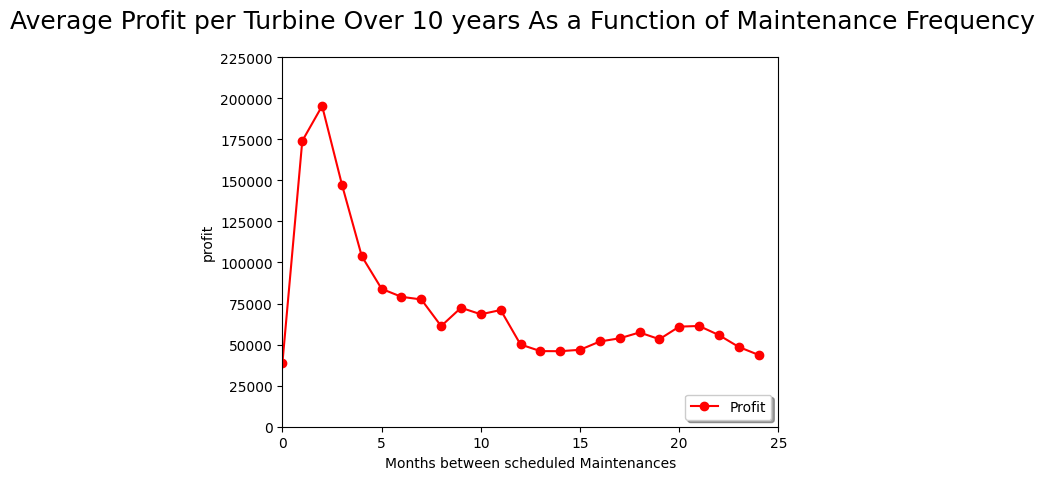

In [ ]:
#Generate plot of data
import matplotlib.pyplot as plt
xvals = range(0, 25)
profit = total_costs
for x in xvals:
  profit[x] = profit[x]/1000
plt.suptitle('Average Profit per Turbine Over 10 years As a Function of Maintenance Frequency',fontsize=18)
plt.xlabel('Months between scheduled Maintenances')
plt.ylabel('profit')
plt.plot(xvals, profit,'ro-',label='Profit')
plt.legend(loc='lower right', shadow=True)
plt.axis([0, 25, 0, 225000])
plt.show()

In [ ]:

# Python3 code to demonstrate working of
# Get values of particular key in list of dictionaries
# Using map() + itemgetter()
from operator import itemgetter

# initializing list
test_list = [{'ab' : 2, 'ba' : 3},
            {'ab' : 1}, {'ab' : 4}]
# printing original list
print("The original list is : " + str(test_list))

# Using map() + itemgetter()
# Get values of particular key in list of dictionaries
res = list(map(itemgetter('ab'), test_list))

# printing result
print("The values corresponding to key : " + str(res))

The original list is : [{'ab': 2, 'ba': 3}, {'ab': 1}, {'ab': 4}]
The values corresponding to key : [2, 1, 4]


In [ ]:

# Python3 code to demonstrate working of
# Get values of particular key in list of dictionaries
# Using map() + itemgetter()
from operator import itemgetter

# initializing list
test_list = [{'gfg' : 1, 'is' : 2, 'good' : 3},
             {'gfg' : 2}, {'best' : 3, 'gfg' : 4}]

# printing original list
print("The original list is : " + str(test_list))

# Using map() + itemgetter()
# Get values of particular key in list of dictionaries
res = list(map(itemgetter('gfg'), test_list))

# printing result
print("The values corresponding to key : " + str(res))

The original list is : [{'gfg': 1, 'is': 2, 'good': 3}, {'gfg': 2}, {'best': 3, 'gfg': 4}]
The values corresponding to key : [1, 2, 4]


In [ ]:
init_normal_weight = 0.8

class Turbine:
  def __init__(self, state):
    init_fail_weight = (1-init_normal_weight)/5
    self.transition_matrix = [[init_normal_weight,init_fail_weight,init_fail_weight,init_fail_weight,init_fail_weight,init_fail_weight],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0]]
    self.schedule = [0,0,0,0,0,0,0,0,0,0,0,0]
    self.state = state
    self.time_since_maintenance= 0
  def update_matrix(self):
    if self.state == "normal":
      self.time_since_maintenance += 1
      self.new_norm_weight = init_normal_weight-(self.time_since_maintenance*0.1)
      self.new_fail_weight = (1-self.new_norm_weight)/5
      self.transition_matrix = [[self.new_norm_weight,self.new_fail_weight,self.new_fail_weight,self.new_fail_weight,self.new_fail_weight,self.new_fail_weight],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0]]
      return self.transition_matrix
    else:
      self.time_since_maintenance = 0
      self.transition_matrix = [[1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0],
                              [1,0,0,0,0,0]]
      return self.transition_matrix
  def get_state(self):
    return self.state

  def get_schedule(self):
    return self.schedule
  def update_schedule(self, schedule):
    self.schedule = schedule



In [ ]:
for i in range(4096):
  binary = format(i, "b")
  plan = [*binary]
  schedule = [int(j) for j in plan]
  while len(schedule) < 12:
    schedule = [0] + schedule
  schedules.append(schedule)

things that need to be done:
1) create function to update transition matrix based on data
2) create for loop to loop through different maintenance schedules to compare
4) put above values in nice graph
3) determine turbine_const
5) determine marginal price values(function of time)
6) potentitally add other metrics


Important Sources:
Equation for power: https://thundersaidenergy.com/downloads/wind-power-impacts-of-larger-turbines/#:~:text=The%20best%20overall%20formula%20for,(in%20meters%20per%20second).

Wind speed in Iowa per month: https://weatherspark.com/y/10312/Average-Weather-in-Des-Moines-Iowa-United-States-Year-Round




updated things that need to be done:

1) make costs of failures a function of time with reasonable dollar cost estimates

2) update transition matricies to have reasonable values in accordance with the data

3) put another for loop for time to run a multi year timeframe

4) put another loop to loop through differenct maininance strategies for the turbines, this is the outer loop and will need associated graphs

5) poster idk

6) Have fun! :)

7) Synergize